# Comparações entre os conjuntos de dados e saidas do dataloader 

To do list:

[] plotar dados de entrada para cada transformada do dataloader
[] plotar dados de entrada para as novas normalizacoes
[] calcular a nova normalizacao dos dados de cada dataset
[] avaliar resultado e funcao do ajuste de gamma 
[] plotar resultados com o dataloader antigo vs os valores neste novo data loader
[] procurar sobre espaços de cores HSV por exemplo que tem o brilho como principal fator
[] Avaliar passar a imagem hsv para o modelo
[] Instalar nvidia/cuda no cluster e avaliar o funcionamento
[] Avaliar a inferencia e como esta sendo passado a alteração de brilho 
[] Ajustar Funções de perda lab e lhc e darkchennel loss
[] Avaliar tabela de losses mapeadas
[] 

In [1]:

import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
#from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.utils.data as data
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
import albumentations as A
from Diffusion import GaussianDiffusionSampler, GaussianDiffusionTrainer
from Diffusion.Model import UNet
from src.Scheduler import GradualWarmupScheduler
from src.tool_func import *
from tensorboardX import SummaryWriter #provavelmente irei retirar o suporte a tensorboard
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM 
from Metrics.metrics import nmetrics
import numpy as np
import glob
import random
import cv2
import colorsys
import os
from typing import Dict, List
import PIL
import lpips as lpips
from PIL import Image
import lpips
import time
import argparse
from tqdm import tqdm
import wandb
import random
from src.split_data import check_alpha_channel, load_image_paths


# Comparacoes usando os dados e a inferencia dos datatasets

Carrega o dataloader original
plota o resultado
carrega o dataloader limpo
plota os reultados
plota um do lado do outro
plota sem os transforms
plota sem as variaveis


In [40]:


class load_data(data.Dataset):
    def __init__(self, input_data_low, input_data_high):
        self.input_data_low = input_data_low
        self.input_data_high = input_data_high
        print("Total training examples:", len(self.input_data_high))
        self.transform=A.Compose(
            [
                A.Resize (height=256, width=256),
                #A.RandomCrop(height=128, width=128),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                ToTensorV2(),
            ]
        )
        


    def __len__(self):  
        return len(self.input_data_low)

    def __getitem__(self, idx):
        seed = torch.random.seed()
        data = []
        data_low = cv2.imread(self.input_data_low[idx])
        data.append(data_low)
        data_low = cv2.convertScaleAbs(data_low, alpha=1.0, beta=-random.randint(50, 100)) #modificação para ajuste automatico de brilho para datalow
        data.append(data_low)
        data_low=data_low[:,:,::-1].copy()
        data.append(data_low)
        random.seed(1)
        data_low=data_low/255.0
        data.append(data_low)

        data_low=np.power(data_low,0.5)#0.25 # Aplicação da correção gamma ajustada para imagens subaquáticas
        data.append(data_low)
        data_low = self.transform(image=data_low)["image"]
        data.append(data_low)
        #mean and var of lol training dataset. If you change dataset, please change mean and var.
        ##RGB normalization
        #mean=torch.tensor([0.2255, 0.4897, 0.4174])
        #var=torch.tensor([0.0259, 0.0338, 0.0383])
        mean=torch.tensor([0.4350, 0.4445, 0.4086])
        var=torch.tensor([0.0193, 0.0134, 0.0199])
        ##BGR normalization
        #mean=torch.tensor([0.4174, 0.4897, 0.2255])
        #var=torch.tensor([0.0383, 0.0338, 0.0259])
        data_low=(data_low-mean.view(3,1,1))/var.view(3,1,1)
        data.append(data_low)
        data_low=data_low/30#20
        data.append(data_low)

        data_max_r=data_low[0].max()
        data_max_g = data_low[1].max()
        data_max_b = data_low[2].max()
        color_max=torch.zeros((data_low.shape[0],data_low.shape[1],data_low.shape[2]))
        color_max[0,:,:]=data_max_r*torch.ones((data_low.shape[1],data_low.shape[2]))    
        color_max[1,:, :] = data_max_g * torch.ones((data_low.shape[1], data_low.shape[2]))
        color_max[2,:, :] = data_max_b * torch.ones((data_low.shape[1], data_low.shape[2]))
        data_color=data_low/(color_max + 1e-6)
        data.append(data_low)
        datah=[]
        data_high = cv2.imread(self.input_data_high[idx])
        datah.append(data_high)

        data_high = cv2.convertScaleAbs(data_high, alpha=1.0, beta=random.randint(50, 100)) #modificação para ajuste automatico de brilho para datalow
        datah.append(data_high)


        data_high=data_high[:,:,::-1].copy()
        datah.append(data_high)

        #data_high = Image.fromarray(data_high)
        random.seed(1)
        data_high = self.transform(image=data_high)["image"]/255.0
        datah.append(data_high)

        data_high=data_high*2-1
        datah.append(data_high)


        data_blur = data_low.permute(1, 2, 0).numpy() * 255.0
        data_blur = cv2.blur(data_blur, (5, 5))
        data_blur = data_blur * 1.0 / 255.0
        data_blur = torch.Tensor(data_blur).float().permute(2, 0, 1)
        datah.append(data_high)


        return [data,datah]



class load_data_test(data.Dataset):
    def __init__(self, input_data_low, input_data_high):
        self.input_data_low = input_data_low
        self.input_data_high = input_data_high
        print("Total test-training examples:", len(self.input_data_high))
        self.transform=A.Compose(
            [
                A.Resize (height=256, width=256),
                ToTensorV2(),
            ]
        )


    def __len__(self):
        return len(self.input_data_low)

    def __getitem__(self, idx):
        seed = torch.random.seed()
        data = []
        data_low = cv2.imread(self.input_data_low[idx])
        data.append({"Data original":data_low})
        #data_low = cv2.convertScaleAbs(data_low, alpha=1.0, beta=-75) #modificação para ajuste automatico de brilho para datalow

        ### Processamento das imagens // Avaliar aplicação // funcionalizar
        # Conversão de canais de cor e normalização
        data_low=data_low[:,:,::-1].copy()
        data.append({ "Data bgr2rgb":data_low})
        random.seed(1)
        data_low=data_low/255.0
        data.append({ "Data /255":data_low})
        # Aplicação de correção gamma
        data_low=np.power(data_low,0.5)
        data.append({"Data ajuste de gamma 0.5":data_low})

        # Transformação e normalização
        data_low = self.transform(image=data_low)["image"]
        data.append({"Data transform":data_low})
        mean=torch.tensor([0.4350, 0.4445, 0.4086])
        var=torch.tensor([0.0193, 0.0134, 0.0199])
        #mean = torch.tensor([0.4174, 0.4897, 0.2255])
        #var = torch.tensor([0.0383, 0.0338, 0.0259])
        #mean=torch.tensor([0.2255, 0.4897, 0.4174])
        #var=torch.tensor([0.0259, 0.0338, 0.0383])
        data_low=(data_low-mean.view(3,1,1))/var.view(3,1,1)
        data.append({"Data normalizacao":data_low})
        data_low=data_low/20
        data.append({"Data escala 20":data_low})

        # Calcular máximos dos canais de cor e normalização de cor
        data_max_r=data_low[0].max()
        data_max_g = data_low[1].max()
        data_max_b = data_low[2].max()
        color_max=torch.zeros((data_low.shape[0],data_low.shape[1],data_low.shape[2]))
        color_max[0,:,:]=data_max_r*torch.ones((data_low.shape[1],data_low.shape[2]))    
        color_max[1,:, :] = data_max_g * torch.ones((data_low.shape[1], data_low.shape[2]))
        color_max[2,:, :] = data_max_b * torch.ones((data_low.shape[1], data_low.shape[2]))
        data_color=data_low/(color_max+ 1e-6)
        data.append({"Data mapa de cor":data_low})
        #data_color = self.transform(data_color)
        #data_color=torch.from_numpy(data_color).float()
        #data_color=data_color.permute(2,0,1)

        # Processamento da imagem de alta luminosidade
        data_high = cv2.imread(self.input_data_high[idx])
        datah = []
        #data_high= cv2.convertScaleAbs(data_high, alpha=1.0, beta=50)
        datah.append({"Data high original":data_high})
        data_high=data_high[:,:,::-1].copy()
        datah.append({"Data high bgr2rgb":data_high})
        #data_high = Image.fromarray(data_high)
        random.seed(1)
        data_high = self.transform(image=data_high)["image"]/255.0
        datah.append({"Data High /255":data_high})
        data_high=data_high*2-1
        datah.append({"Data high reescala -1 e 1":data_high})

        #normalization
        #data_high=data_high**0.25

        # Desfocagem e preparação do retorno
        data_blur = data_low.permute(1, 2, 0).numpy() * 255.0
        data_blur = cv2.blur(data_blur, (5, 5))
        data_blur = data_blur * 1.0 / 255.0
        data_blur = torch.Tensor(data_blur).float().permute(2, 0, 1)


        return [data,datah]
    
    class load_data_inf(data.Dataset):
        def __init__(self, input_data_low):
            self.input_data_low = input_data_low
            print("Total test-training examples:", len(self.input_data_low))
            self.transform=A.Compose(
                [
                    A.Resize (height=256, width=256),
                    ToTensorV2(),
                ]
            )
        def ___len__(self):
            return len(self.input_data_low)
        def __getitem__(self, idx):
            seed = torch.random.seed()
            data_low = cv2.imread(self.input_data_low[idx])
            
            return [self.input_data_low[idx]]




Total training examples: 161
9 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5  image  torch.Size([1, 3, 256, 256])
6  image  torch.Size([1, 3, 256, 256])
7  image  torch.Size([1, 3, 256, 256])
8  image  torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


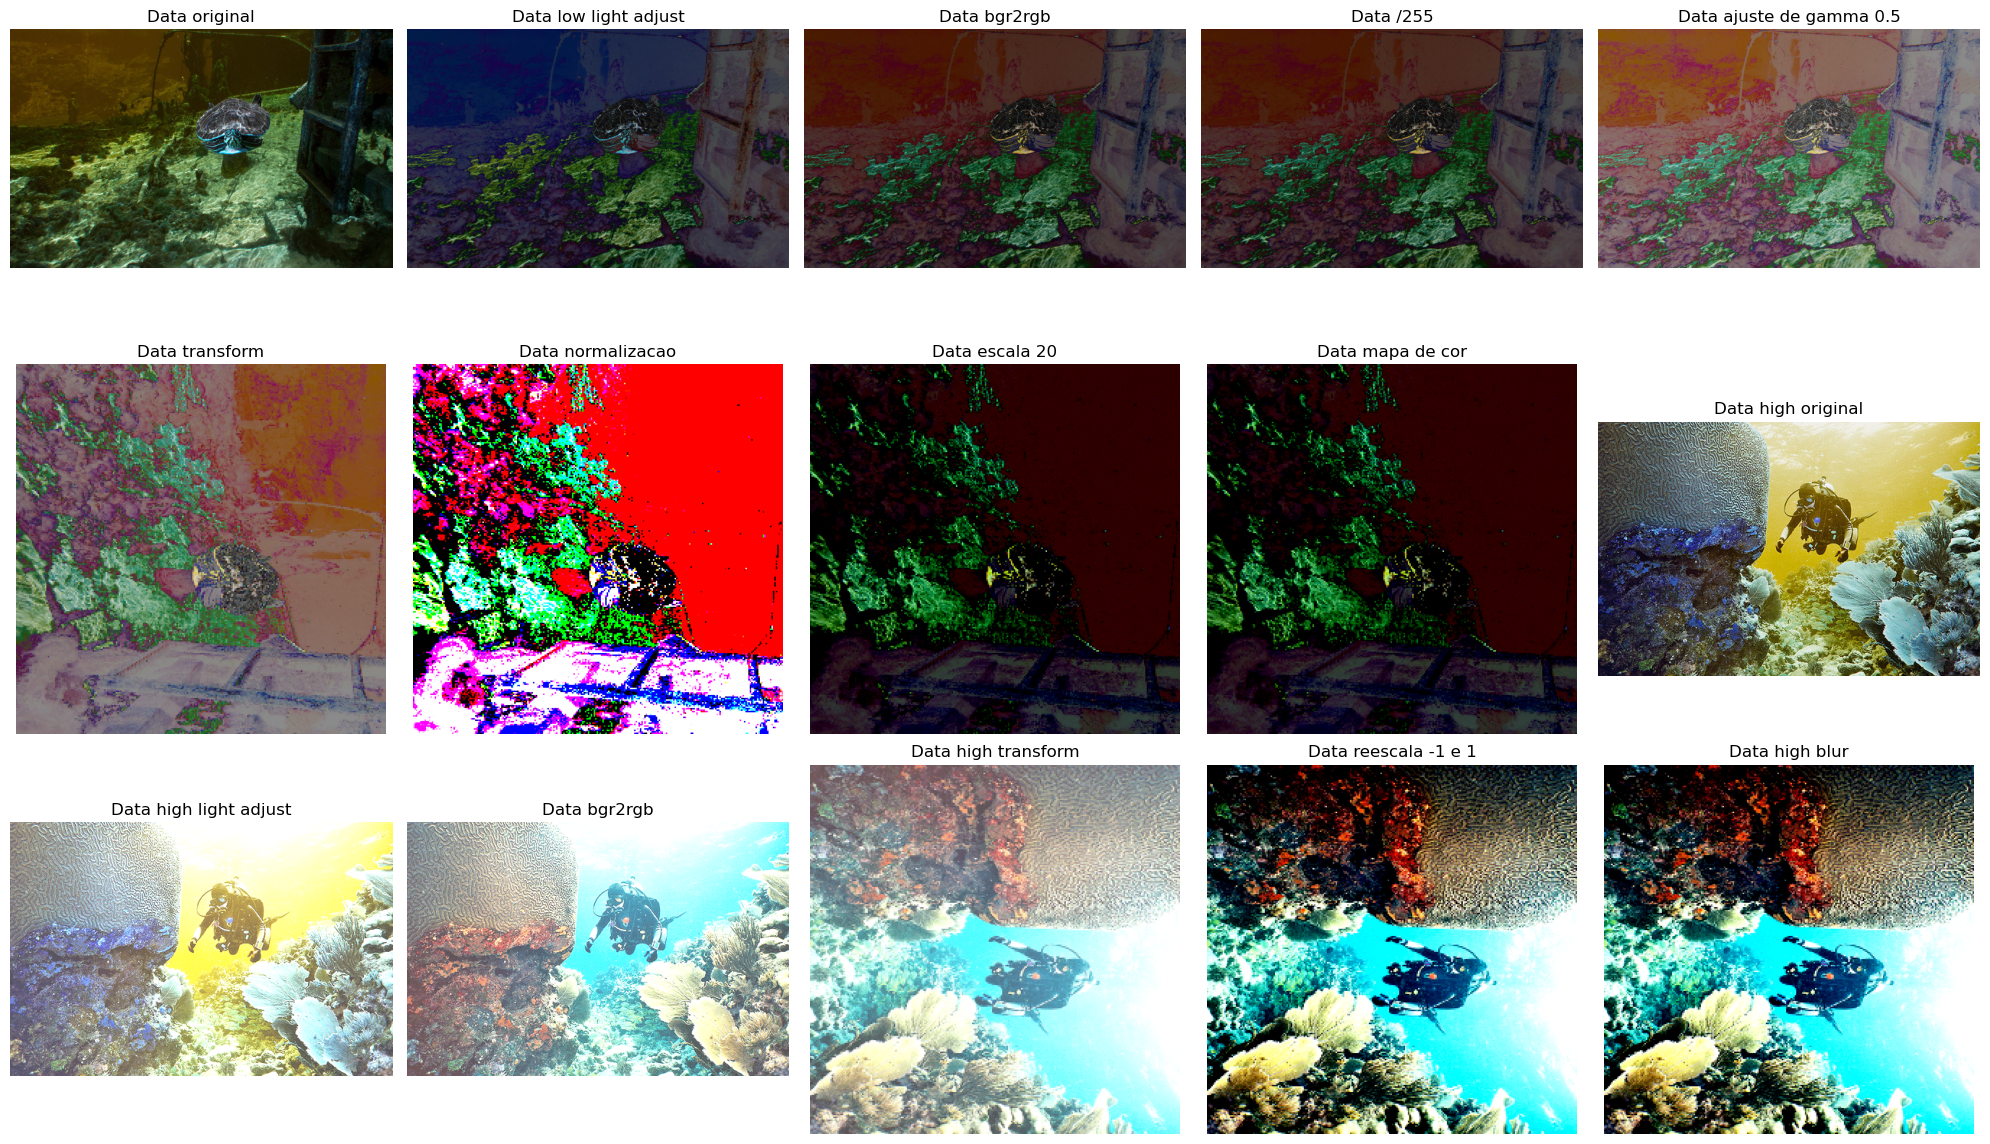

In [47]:
import matplotlib.pyplot as plt
from src.split_data import load_image_paths
from pprint import pprint as pp
#plotar imagens
input_data_low, input_data_high= load_image_paths(dataset_path="data/UDWdata" ,dataset="UIEB", split=True, task="train")
 
load = load_data(input_data_low, input_data_high)
#load_test = load_data_test(input_data_low, input_data_high)

load_treino = DataLoader(load, batch_size=1, num_workers=4,
                            drop_last=True, pin_memory=True)
""" load_test = DataLoader(load_test, batch_size=1, num_workers=4,
                            drop_last=True, pin_memory=True) """
# Iterar sobre os dados e visualizar as imagens

# image, imageh = next(iter(load_treino))
# for i in range(len(image)):
#     print("image ", image[i].shape)
# for i in range (len(imageh)):
#     print("imageh ", imageh[i].shape)


# print("""


# """)
# Lista de legendas
legends = [
    "Data original",
    "Data low light adjust",
    "Data bgr2rgb",
    "Data /255",
    "Data ajuste de gamma 0.5",
    "Data transform",
    "Data normalizacao",
    "Data escala 20",
    "Data mapa de cor",
]
legendsh = [
    "Data high original",
    "Data high light adjust",
    "Data bgr2rgb",
    "Data high transform",
    "Data reescala -1 e 1",
    "Data high blur"
    ]
# Configurar subplots
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
axs = axs.flatten()
for image, imageh in load_treino:    
    print(len(image), len(imageh))
    a = 0
    for i in range(15):
        if i < 5:  # Primeiros 9 são da imagem
            img = image[i].squeeze(0)
            #print(i," image ", image[i].shape)

            img = img.numpy()

            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(legends[i])
        elif i < 9: # Últimos 5 são da imagemh

            img = image[i].squeeze(0)
            print(i," image ", image[i].shape)

            img = img.permute(2,1,0).numpy() 
            #print(img.shape)

            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(legends[i])
        else:

            if a<3:
                img = imageh[a].squeeze(0)
                img = img.numpy() 
                axs[i].imshow(img)
                axs[i].axis('off')
                axs[i].set_title(legendsh[a])
            else:
                img = imageh[a].squeeze(0)
                img = img.permute(2, 1, 0).numpy()
                axs[i].imshow(img)
                axs[i].axis('off')
                axs[i].set_title(legendsh[a])
            a+=1

    plt.tight_layout()
    plt.show()

    break  # Para sair do loop após o primeiro lote

In [18]:
x = torch.ones(1, 3, 480, 640)#(3, 256, 256)
x = x.squeeze(0)
print(x.shape)
x = x.permute( 2, 1, 0).numpy()
print(x.shape)

torch.Size([3, 480, 640])
(640, 480, 3)


In [48]:
from loss import DarkChannelPriorLoss, lab_Loss, lch_Loss
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from src.split_data import load_image_paths
import random
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import numpy as np

class load_data(data.Dataset):
    def __init__(self, input_data_low, input_data_high):
        self.input_data_low = input_data_low
        self.input_data_high = input_data_high
        print("Total training examples:", len(self.input_data_high))
        self.transform=A.Compose(
            [
                A. Resize (height=256, width=256),
                # A.RandomCrop(height=128, width=128),
                # A.HorizontalFlip(p=0.5),
                # A.VerticalFlip(p=0.5),
                ToTensorV2()
            ]
        )


    def __len__(self):  
        return len(self.input_data_low)

    def __getitem__(self, idx):
        seed = torch.random.seed()
        data_low = cv2.imread(self.input_data_low[idx])


        random.seed(1)
        data_low=data_low/255.0
        data_low = self.transform(image=data_low)["image"]

        return data_low
    
# Defina as transformações necessárias para as imagens
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = "UIEB"
# Carregue o dataset
datapath_train = load_image_paths(dataset_path="data/UDWdata/", dataset=dataset)
print(len(datapath_train))
train_loader=load_data(datapath_train, datapath_train)
# Inicialize DataLoader
dataloader = DataLoader(train_loader, batch_size=32, shuffle=False, num_workers=4)

# Inicialize variáveis de acumulação
mean = torch.zeros(3)
mean_square = torch.zeros(3)
total_pixels = 0

# Itere pelo dataset
for images in dataloader:
    #print(images)
    # Obtenha o número de pixels em um lote
    num_pixels = images.size(0) * images.size(2) * images.size(3)
    total_pixels += num_pixels
    
    # Acumule as somas dos canais de cor
    mean += images.sum(dim=[0, 2, 3])
    mean_square += (images ** 2).sum(dim=[0, 2, 3])
    #print(d(images).item(),lab(images,images).item(), lch(images,images).item())
   #print(d(images).item())

# Calcule a média dos canais de cor
mean /= total_pixels

# Calcule a variância dos canais de cor
var = (mean_square / total_pixels) - (mean ** 2)

print(f'Média dos canais de cor: {mean}')
print(f'Variância dos canais de cor: {var}')
# Nome do arquivo que você deseja escrever
filename = "data/"+dataset+'_norma.txt'

# O valor que você deseja escrever no arquivo
valor = f"""
Média dos canais de cor: {mean}
Variância dos canais de cor: {var}
"""

# Abrindo o arquivo em modo de escrita ('w') que sobrescreverá o arquivo se ele já existir
with open(filename, 'w') as file:
    file.write(valor)

print(f'O arquivo {filename} foi criado/sobrescrito com sucesso.')
#testar as normalizacoes com os resultados ruins para os dados do dataloader

89
Total training examples: 89
Média dos canais de cor: tensor([0.4640, 0.4843, 0.2748])
Variância dos canais de cor: tensor([0.0509, 0.0422, 0.0487])
O arquivo data/UIEB_norma.txt foi criado/sobrescrito com sucesso.


In [ ]:
mean = torch.tensor([0.4640, 0.4843, 0.2748])
var=torch.tensor([0.0509, 0.0422, 0.0487])

In [4]:
def Test(config: Dict,epoch):

    ###load the data
    datapath_test = load_image_paths(config.dataset_path,config.dataset,split=False)

    # load model and evaluate
    device = config.device_list[0]
    # test_low_path=config.dataset_path+r'*.png'    
    # test_high_path=config.dataset_path+r'*.png' 

    # datapath_test_low = glob.glob( test_low_path)
    # datapath_test_high = glob.glob(test_high_path)

    dataload_test = load_data_test(datapath_test,datapath_test)
    dataloader = DataLoader(dataload_test, batch_size=1, num_workers=4,
                            drop_last=True, pin_memory=True)


    model = UNet(T=config.T, ch=config.channel, ch_mult=config.channel_mult,
                 attn=config.attn,
                 num_res_blocks=config.num_res_blocks, dropout=0.)
    #Mudar um pouco aqui para carregar o checkpoint do dataset escolhido
    ckpt_path=config.output_path+'ckpt/'+ config.dataset +'/ckpt_'+str(epoch)+'_.pt'
    ckpt = torch.load(ckpt_path,map_location='cpu')
    model.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()})
    print("model load weight done.")
    save_dir=config.output_path+'/result/'+ config.dataset +'/epoch/'+str(epoch)+'/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print(f"savedir: {save_dir}, ckpt_path: {ckpt_path}")
    # save_txt_name =save_dir + 'res.txt'
    # f = open(save_txt_name, 'w+')
    # f.close()
        
    image_num = 0
    psnr_list = []
    ssim_list = []
    #lpips_list=[]
    uciqe_list = []
    uiqm_list =[]
    wout = []

""" 
    model.eval()
    sampler = GaussianDiffusionSampler(
        model, config.beta_1, config.beta_T, config.T).to(device)
    #loss_fn_vgg=lpips.LPIPS(net='vgg')

    with torch.no_grad():
        with tqdm( dataloader, dynamic_ncols=True) as tqdmDataLoader:
                image_num = 0
                for data_low, data_high, data_color,data_blur,filename in tqdmDataLoader:
                    name=filename[0].split('/')[-1]
                    print('Image:',name)
                    gt_image = data_high.to(device)
                    lowlight_image = data_low.to(device)
                    data_color = data_color.to(device)
                    data_blur=data_blur.to(device)
                    snr_map = getSnrMap(lowlight_image, data_blur)
                    data_concate=torch.cat([data_color, snr_map], dim=1)

                    #for i in range(-10, 10,1): 
                        # light_high = torch.ones([1]) * i*0.1
                        # light_high = light_high.to(device)
                        
                    brightness_level=gt_image.mean([1, 2, 3]) # b*1
                    time_start = time.time()
                    sampledImgs = sampler(lowlight_image, data_concate,brightness_level,ddim=True,
                                          unconditional_guidance_scale=1,ddim_step=config.ddim_step)
                    time_end=time.time()
                    print('time cost:', time_end - time_start)

                    sampledImgs=(sampledImgs+1)/2
                    gt_image=(gt_image+1)/2
                    lowlight_image=(lowlight_image+1)/2
                    res_Imgs=np.clip(sampledImgs.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1] 
                    gt_img=np.clip(gt_image.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1]
                    low_img=np.clip(lowlight_image.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1]
                    
                    
                    # Compute METRICS
                    ## compute psnr
                    psnr = PSNR(res_Imgs, gt_img)
                    #ssim = SSIM(res_Imgs, gt_img, channel_axis=2,data_range=255)
                    res_gray = rgb2gray(res_Imgs)
                    gt_gray = rgb2gray(gt_img)

                    ssim_score = SSIM(res_gray, gt_gray, multichannel=True,data_range=1)\
                    
                    #UIQM e UCIQE
                    uiqm,uciqe = nmetrics(res_Imgs)
                   
                    res_Imgs = (res_Imgs * 255)
                    gt_img = (gt_img * 255)
                    low_img = (low_img * 255)
                    
                    psnr_list.append(psnr)
                    ssim_list.append(ssim_score)
                    uiqm_list.append(uiqm)
                    uciqe_list.append(uciqe)
                    

                    #send wandb
                    output = np.concatenate([low_img, gt_img, res_Imgs], axis=1) / 255
                    #image = wandb.Image(output, caption="Low image, High Image, Enhanced Image")
                    #wout.append(image)

                    # show result
                    # output = np.concatenate([low_img, gt_img, res_Imgs, res_trick], axis=1) / 255
                    # plt.axis('off')
                    # plt.imshow(output)
                    # plt.show()
                    #save_path = save_dir + name
                    #cv2.imwrite(save_path, output * 255)

                    #save_path =save_dir+ name+'.png'
                    #cv2.imwrite(save_path, res_Imgs)
                
                #Metrics
  
                avg_psnr = sum(psnr_list) / len(psnr_list)
                avg_ssim = sum(ssim_list) / len(ssim_list)
                avg_uiqm = sum(uiqm_list) / len(uiqm_list)
                avg_uciqe = sum(uciqe_list) / len(uciqe_list)

                # Wandb logs 
                wandb.log({"Inferecia "+config.dataset:{
                    "Average PSNR": avg_psnr,
                    "Average SSIM": avg_ssim,
                    "Average UIQM": avg_uiqm,
                    "Average UCIQE": avg_uciqe,
                    "PSNR": psnr,
                    "SSIM": ssim_score,
                    "Test from epoch": epoch,
                    "Image ":wout
                    }})

                #print('psnr_orgin_avg:', avg_psnr)
                #print('ssim_orgin_avg:', avg_ssim)
                print(f"Test From epoch {epoch} DONE")

                # f = open(save_txt_name, 'w+')
                # f.write('\npsnr_orgin :')
                # f.write(str(psnr_list))
                # f.write('\nssim_orgin :')
                # f.write(str(ssim_list))

                # f.write('\npsnr_orgin_avg:')
                # f.write(str(avg_psnr))
                # f.write('\nssim_orgin_avg:')
                # f.write(str(avg_ssim))
                # f.close()

                #return avg_psnr,avg_ssim
 """



In [ ]:

def Testi(config: Dict,epoch):

    ###load the data
    datapath_test = load_image_paths(config.dataset_path,config.dataset,split=False)[:5]

    # load model and evaluate
    device = config.device_list[0]
    # test_low_path=config.dataset_path+r'*.png'    
    # test_high_path=config.dataset_path+r'*.png' 

    # datapath_test_low = glob.glob( test_low_path)
    # datapath_test_high = glob.glob(test_high_path)

    dataload_test = load_data_test(datapath_test,datapath_test)
    dataloader = DataLoader(dataload_test, batch_size=1, num_workers=4,
                            drop_last=True, pin_memory=True)


    model = UNet(T=config.T, ch=config.channel, ch_mult=config.channel_mult,
                 attn=config.attn,
                 num_res_blocks=config.num_res_blocks, dropout=0.)
    #Mudar um pouco aqui para carregar o checkpoint do dataset escolhido
    ckpt_path=config.output_path+'ckpt/'+ config.dataset +'/ckpt_'+str(epoch)+'_.pt'
    ckpt = torch.load(ckpt_path,map_location='cpu')
    model.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()})
    print("model load weight done.")
    save_dir=config.output_path+'result/'+ config.dataset+'/ctrl' +'/epoch/'+str(epoch)+'/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save_txt_name =save_dir + 'res.txt'
    # f = open(save_txt_name, 'w+')
    # f.close()

    image_num = 0
    psnr_list = []
    ssim_list = []
    #lpips_list=[]
    uciqe_list = []
    uiqm_list =[]
    wout = []


    model.eval()
    sampler = GaussianDiffusionSampler(
        model, config.beta_1, config.beta_T, config.T).to(device)
    #loss_fn_vgg=lpips.LPIPS(net='vgg')

    with torch.no_grad():
        with tqdm( dataloader, dynamic_ncols=True) as tqdmDataLoader:
                image_num = 0
                for data_low, data_high, data_color,data_blur,filename in tqdmDataLoader:
                    name=filename[0].split('/')[-1]
                    print('Image:',name)
                    gt_image = data_high.to(device)
                    lowlight_image = data_low.to(device)
                    data_color = data_color.to(device)
                    data_blur=data_blur.to(device)
                    snr_map = getSnrMap(lowlight_image, data_blur)
                    data_concate=torch.cat([data_color, snr_map], dim=1)

                    for i in range(-8, 8): 
                        light_high = torch.ones([1]) * i*0.1
                        light_high = light_high.to(device)
                        
                        brightness_level=gt_image.mean([1, 2, 3]) # b*1
                        time_start = time.time()
                        sampledImgs = sampler(lowlight_image, data_concate,brightness_level,ddim=True,
                                            unconditional_guidance_scale=1,ddim_step=config.ddim_step)
                        time_end=time.time()
                        print('time cost:', time_end - time_start)

                        sampledImgs=(sampledImgs+1)/2
                        gt_image=(gt_image+1)/2
                        lowlight_image=(lowlight_image+1)/2
                        res_Imgs=np.clip(sampledImgs.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1] 
                        gt_img=np.clip(gt_image.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1]
                        low_img=np.clip(lowlight_image.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1]
                        
                        
                        # # Compute METRICS
                        # ## compute psnr
                        # psnr = PSNR(res_Imgs, gt_img)
                        # #ssim = SSIM(res_Imgs, gt_img, channel_axis=2,data_range=255)
                        # res_gray = rgb2gray(res_Imgs)
                        # gt_gray = rgb2gray(gt_img)

                        # ssim_score = SSIM(res_gray, gt_gray, multichannel=True,data_range=1)\
                        
                        # #UIQM e UCIQE
                        # uiqm,uciqe = nmetrics(res_Imgs)
                    
                        res_Imgs = (res_Imgs * 255)
                        gt_img = (gt_img * 255)
                        low_img = (low_img * 255)
                        
                        # psnr_list.append(psnr)
                        # ssim_list.append(ssim_score)
                        #uiqm_list.append(uiqm)
                        #uciqe_list.append(uciqe)
                        

                        #send wandb
                        output = np.concatenate([low_img, gt_img, res_Imgs], axis=1) / 255
                        image = wandb.Image(output, caption="Low image, High Image, Control Enhanced Image")
                        wout.append(image)

                        # show result
                        # output = np.concatenate([low_img, gt_img, res_Imgs, res_trick], axis=1) / 255
                        # plt.axis('off')
                        # plt.imshow(output)
                        # plt.show()
                        #save_path = save_dir + name
                        #cv2.imwrite(save_path, output * 255)

                        save_path =save_dir+ name+'.png'
                        cv2.imwrite(save_path, res_Imgs)
                
                #Metrics
  
                # avg_psnr = sum(psnr_list) / len(psnr_list)
                # avg_ssim = sum(ssim_list) / len(ssim_list)
                # avg_uiqm = sum(uiqm_list) / len(uiqm_list)
                # avg_uciqe = sum(uciqe_list) / len(uciqe_list)

                # Wandb logs 
                wandb.log({"Inferecia "+config.dataset:{
                    "Test from epoch": epoch,
                    "Image Ajuste ":wout
                    }})

                #print('psnr_orgin_avg:', avg_psnr)
                #print('ssim_orgin_avg:', avg_ssim)
                print(f"Test From epoch {epoch} DONE")

                # f = open(save_txt_name, 'w+')
                # f.write('\npsnr_orgin :')
                # f.write(str(psnr_list))
                # f.write('\nssim_orgin :')
                # f.write(str(ssim_list))

                # f.write('\npsnr_orgin_avg:')
                # f.write(str(avg_psnr))
                # f.write('\nssim_orgin_avg:')
                # f.write(str(avg_ssim))
                # f.close()

                #return avg_psnr,avg_ssim

def Inference(config: Dict):
   ###load the data
    datapath_test = load_image_paths(config.dataset_path,config.dataset, split=False)

    # load model and evaluate
    device = config.device_list[0]

    dataload_test = load_data_test(datapath_test,datapath_test)
    dataloader = DataLoader(dataload_test, batch_size=1, num_workers=4,
                            drop_last=True, pin_memory=True)

    model = UNet(T=config.T, ch=config.channel, ch_mult=config.channel_mult,
                 attn=config.attn,
                 num_res_blocks=config.num_res_blocks, dropout=0.)
    ckpt_path=config.pretrained_path
    
    ckpt = torch.load(ckpt_path,map_location='cpu')
    model.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()})
    print("model load weight done.")
    
    save_dir=config.output_path+'/result/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_txt_name =save_dir + 'res.txt'
    #f = open(save_txt_name, 'w+')
    #f.close()


    model.eval()
    sampler = GaussianDiffusionSampler(
        model, config.beta_1, config.beta_T, config.T).to(device)
    #loss_fn_vgg=lpips.LPIPS(net='vgg')

    with torch.no_grad():
        with tqdm( dataloader, dynamic_ncols=True) as tqdmDataLoader:
                image_num = 0
                for data_low, data_color,data_blur in tqdmDataLoader:
                    lowlight_image = data_low.to(device)

                    data_color = data_color.to(device)
                    data_blur=data_blur.to(device)
                    snr_map = getSnrMap(lowlight_image, data_blur)
                    
                    #mask = mask.numpy()
                    # print('type:',type(mask))
                    print('data low shape:',data_low.shape)
                    
                    #print('mask shape:',mask.shape)
                    # mask=cv2.resize(mask,(data_low.shape[2],data_low.shape[3]))
                    mask=cv2.GaussianBlur(mask, (25, 25), 0)
                    mask=torch.from_numpy(mask).to(device)
                    # mask = torch.unsqueeze(mask, 0).to(device)
                    # mask = np.ones([400, 600,1]) * 0
                    # mask=torch.unsqueeze(mask,0).to(device)
                    # mask[:, :, 100:400, 100:400] = 1
                    
                    data_concate=torch.cat([data_color, snr_map,mask], dim=1)

                    for i in range(-8, 8): 
                        brightness_level = torch.ones([1]) * i
                        brightness_level = brightness_level.to(device)
                        
                        time_start = time.time()
                        sampledImgs = sampler(lowlight_image, data_concate,brightness_level,ddim=True,
                                            unconditional_guidance_scale=1,ddim_step=config.ddim_step)
                        time_end=time.time()
                        print('time cost:', time_end - time_start)

                        sampledImgs=(sampledImgs+1)/2
                        res_Imgs=np.clip(sampledImgs.detach().cpu().numpy()[0].transpose(1, 2, 0),0,1)[:,:,::-1] 

                        wandb.log({"Inference CLE_mask_DIF":
                                   {"Mask Image Inference": [wandb.Image(res_Imgs, caption="Image")],
                                   "Mask Image Inference *255": [wandb.Image(res_Imgs*255, caption="Image")]}})
                        save_path =save_dir+ config.data_name+'_level'+str(i)+'.png'
                        print(save_path)
                        cv2.imwrite(save_path, res_Imgs*255)
    


In [ ]:

if __name__== "__main__" :
    parser = argparse.ArgumentParser()
    modelConfig = {
  
        "DDP": False,
        "state": "val", # or eval
        "epoch": 601,#10001,
        "batch_size":16 ,
        "T": 1000,
        "channel": 128,
        "channel_mult": [1, 2, 3, 4],
        "attn": [2],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 5e-5,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 32,
        "grad_clip": 1.,
        "device": "cuda", #MODIFIQUEI
        "device_list": [0],
        #"device_list": [3,2,1,0],
        
        "ddim":True,
        "unconditional_guidance_scale":1,
        "ddim_step":100
    }


    parser.add_argument('--dataset_path', type=str, default="./data/UDWdata/")
    parser.add_argument('--dataset', type=str, default="all") # RUIE, UIEB, SUIM
    parser.add_argument('--state', type=str, default="train")  #or eval
    parser.add_argument('--pretrained_path', type=str, default=None)  #or eval ajustar pastas para salvar os conteudos
    parser.add_argument('--output_path', type=str, default="./output/")  #or eval

    config = parser.parse_args()
    
    wandb.init(
            project="CLEDiffusion",
            config=vars(config),
            name="Treino Diffusao sem mascaras",
            tags=["Train","No mask"],
            group="diffusion_train",
            job_type="train",

        )
    
    for key, value in modelConfig.items():
        setattr(config, key, value)
    print(config)
    Test(config,1000)

    #Inference(config)
    wandb.finish()
    #Test_for_one(modelConfig,epoch=14000)